In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
import torch
import torch.nn as nn

100%|██████████| 50/50 [00:00<00:00, 1169.16it/s]


Animation saved as 'vlasov_analytical.gif'


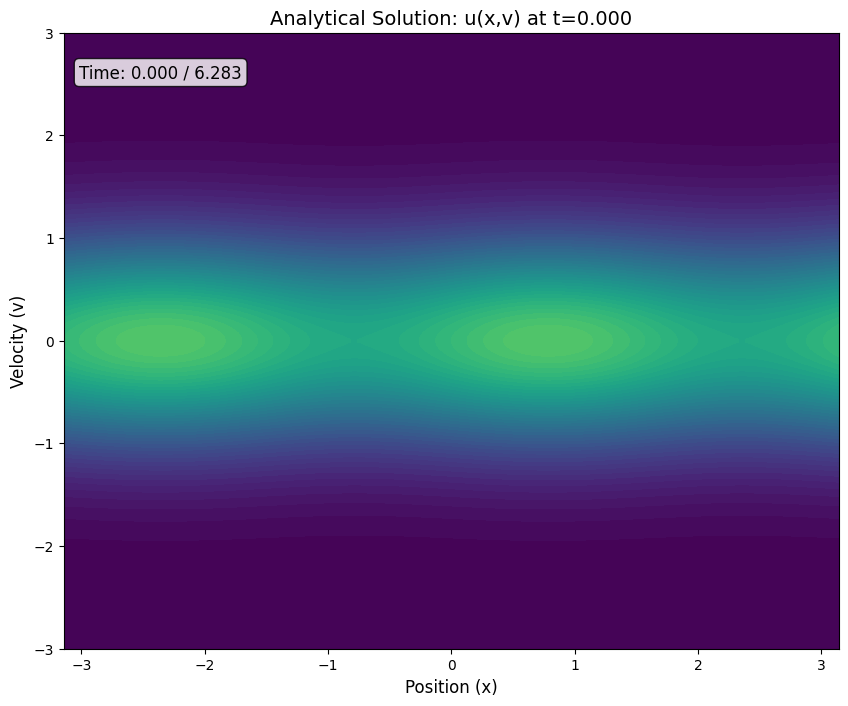

In [2]:
alpha = 0.1
t_max = 2 * np.pi
n_frames = 50

nx = 200 
nv = 200
x = np.linspace(-np.pi, np.pi, nx)
v = np.linspace(-3, 3, nv)

X, V = np.meshgrid(x, v, indexing='ij')

def analytical_solution(t, x, v):
    x_shifted = (x - v * t + np.pi) % (2 * np.pi) - np.pi
    return np.exp(-v**2) * (1 + alpha * np.sin(2 * x_shifted))

t_frames = np.linspace(0, t_max, n_frames)
u_analytical = []

for t_val in tqdm(t_frames):
    u_ana = analytical_solution(t_val, X, V)
    u_analytical.append(u_ana)

fig, ax = plt.subplots(figsize=(10, 8))

def animate_solution(frame):
    ax.clear()
    
    contour = ax.contourf(x, v, u_analytical[frame].T, levels=50, cmap='viridis', vmin=0, vmax=1.5)
    ax.set_xlabel('Position (x)', fontsize=12)
    ax.set_ylabel('Velocity (v)', fontsize=12)
    ax.set_title(f'Analytical Solution: u(x,v) at t={t_frames[frame]:.3f}', fontsize=14)
    
    ax.text(0.02, 0.95, f'Time: {t_frames[frame]:.3f} / {2*np.pi:.3f}', 
            transform=ax.transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    return contour,

anim = FuncAnimation(fig, animate_solution, frames=n_frames, interval=100, blit=False, repeat=True)

anim.save('vlasov_analytical.gif', writer='pillow', fps=10, dpi=100)
print("Animation saved as 'vlasov_analytical.gif'")

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, t, x, v):
        inputs = torch.cat([t, x, v], dim=1)
        return self.net(inputs)
    
    
model = PINN().to(device)
model.load_state_dict(torch.load('pinn_vlasov_model.pth'))

<All keys matched successfully>

Computing PINN and analytical solutions...


100%|██████████| 50/50 [00:00<00:00, 213.47it/s]


Animation saved as 'vlasov_pinn_vs_analytical.gif'


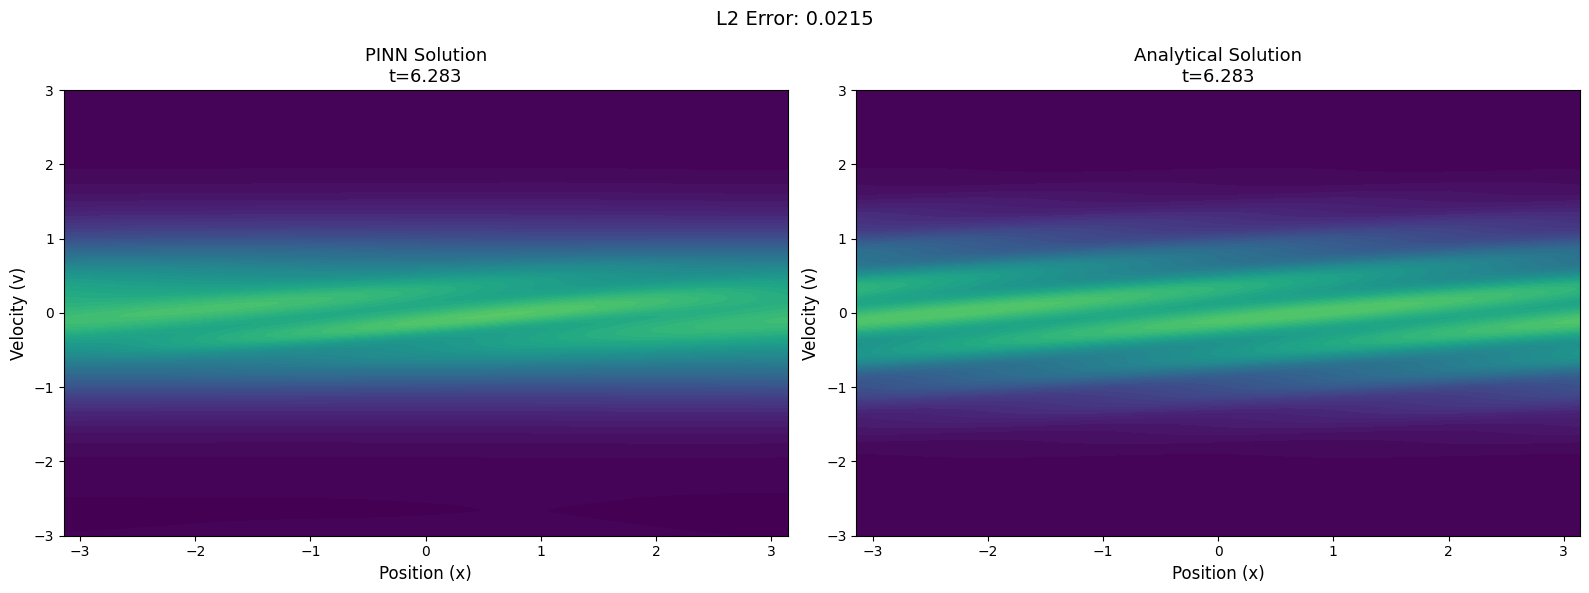

Error plot saved as 'pinn_error_evolution.png'


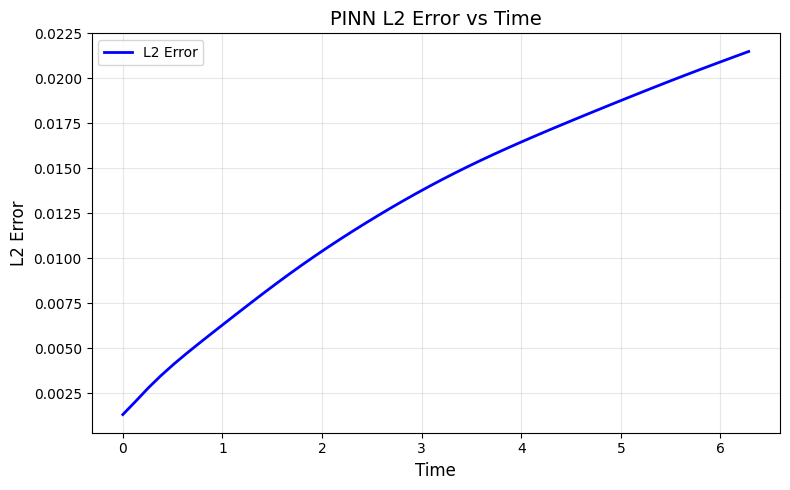

PINN vs ANALYTICAL SOLUTION - ERROR SUMMARY
Initial L2 Error:  1.315877e-03
Final L2 Error:    2.149228e-02
Mean L2 Error:     1.319796e-02
Max L2 Error:      2.149228e-02


In [4]:
u_pinn = []
u_analytical = []

print("Computing PINN and analytical solutions...")
with torch.no_grad():
    for t_val in tqdm(t_frames):
        X_flat = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1).to(device)
        V_flat = torch.tensor(V.flatten(), dtype=torch.float32).view(-1, 1).to(device)
        T_flat = torch.full_like(X_flat, t_val).to(device)
        
        u_pred = model(T_flat, X_flat, V_flat).cpu().numpy().reshape(X.shape)
        u_pinn.append(u_pred)
        
        # Analytical solution
        u_ana = analytical_solution(t_val, X, V)
        u_analytical.append(u_ana)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

def animate_comparison(frame):
    for ax in axes:
        ax.clear()
    
    contour1 = axes[0].contourf(x, v, u_pinn[frame].T, levels=50, cmap='viridis', vmin=0, vmax=1.5)
    axes[0].set_xlabel('Position (x)', fontsize=12)
    axes[0].set_ylabel('Velocity (v)', fontsize=12)
    axes[0].set_title(f'PINN Solution\nt={t_frames[frame]:.3f}', fontsize=13)
    
    contour2 = axes[1].contourf(x, v, u_analytical[frame].T, levels=50, cmap='viridis', vmin=0, vmax=1.5)
    axes[1].set_xlabel('Position (x)', fontsize=12)
    axes[1].set_ylabel('Velocity (v)', fontsize=12)
    axes[1].set_title(f'Analytical Solution\nt={t_frames[frame]:.3f}', fontsize=13)
    
    error = np.abs(u_pinn[frame] - u_analytical[frame])
    error_text = f'L2 Error: {np.sqrt(np.mean(error**2)):.4f}'
    fig.suptitle(error_text, fontsize=14, y=0.98)
    
    return contour1, contour2

anim = FuncAnimation(fig, animate_comparison, frames=n_frames, interval=100, blit=False, repeat=True)

anim.save('vlasov_pinn_vs_analytical.gif', writer='pillow', fps=10, dpi=100)
print("Animation saved as 'vlasov_pinn_vs_analytical.gif'")

plt.tight_layout()
plt.show()

errors_L2 = []

for i in range(n_frames):
    error = u_pinn[i] - u_analytical[i]
    errors_L2.append(np.sqrt(np.mean(error**2)))

# Plot errors
fig, axes = plt.subplots(figsize=(8, 5))

axes.plot(t_frames, errors_L2, 'b-', linewidth=2, label='L2 Error')
axes.set_xlabel('Time', fontsize=12)
axes.set_ylabel('L2 Error', fontsize=12)
axes.set_title('PINN L2 Error vs Time', fontsize=14)
axes.grid(True, alpha=0.3)
axes.legend()


plt.tight_layout()
plt.savefig('pinn_error_evolution.png', dpi=150, bbox_inches='tight')
print("Error plot saved as 'pinn_error_evolution.png'")
plt.show()




print("PINN vs ANALYTICAL SOLUTION - ERROR SUMMARY")
print(f"Initial L2 Error:  {errors_L2[0]:.6e}")
print(f"Final L2 Error:    {errors_L2[-1]:.6e}")
print(f"Mean L2 Error:     {np.mean(errors_L2):.6e}")
print(f"Max L2 Error:      {np.max(errors_L2):.6e}")

In [5]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn_param=1
        for s in list(p.size()):
            nn_param = nn_param*s
        pp += nn_param
    return pp


print(f"Number of parameters: {get_n_params(model)}")

Number of parameters: 2801
